# Training simple CNN to classify CIFAR10 dataset

The implementation of the CNN net is taken from the: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

According to that file:
```
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
```

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
import tensorflow as tf
tf.__version__

'1.7.0'

In [3]:
import sys
sys.path.append("../src/")
import keras_cifar_cnn as cnn
import tf_optimizer as tf_opt
import callbacks as clb
import utils as ut
from plotting import set_display_settings
set_display_settings()

from keras.optimizers import TFOptimizer
from keras.callbacks import History

Using TensorFlow backend.


## Dataset and model definition

In [4]:
x_train, y_train, validation_set, datagen = cnn.get_dataset()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
model = cnn.get_cnn()
batch_size = 32

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

# Train model with `NormalizedSGD`

In [7]:
norms = ['max', 'min_max', 'std']
metrics_norms = {}

In [14]:
model = cnn.get_cnn()
metrics_history = [clb.AggregateMetricsOnBatchEnd(), clb.AggregateMetricsOnEpochEnd()]

for norm in norms:   
    print('testing norm:', norm)    
    model = cnn.get_cnn()
    metrics_history = [clb.AggregateMetricsOnBatchEnd(), clb.AggregateMetricsOnEpochEnd()]
    
    lrs = [0.005, 0.001, 0.0001, 0.00001]
    if norm == 'std':
        lrs = [0.001, 0.0005, 0.0001, 0.00001]
        
    for lr in lrs:
        optimizer = TFOptimizer(tf_opt.NormalizedSGD(lr=lr, norm=norm))
        model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(
            x=x_train, y=y_train, 
            batch_size=batch_size, epochs=15, 
            validation_data=validation_set, 
            callbacks=metrics_history)
            
    metrics_norms[norm] = metrics_history

testing norm: std
Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 18s 357us/step - loss: 1.7602 - acc: 0.3578 - val_loss: 1.4780 - val_acc: 0.4671
Epoch 2/15
50000/50000 [==============================] - 17s 333us/step - loss: 1.3277 - acc: 0.5229 - val_loss: 1.0569 - val_acc: 0.6288
Epoch 3/15
50000/50000 [==============================] - 17s 331us/step - loss: 1.1384 - acc: 0.5991 - val_loss: 1.0040 - val_acc: 0.6446
Epoch 4/15
50000/50000 [==============================] - 17s 331us/step - loss: 1.0110 - acc: 0.6445 - val_loss: 0.9049 - val_acc: 0.6776
Epoch 5/15
50000/50000 [==============================] - 17s 337us/step - loss: 0.9208 - acc: 0.6791 - val_loss: 0.8694 - val_acc: 0.6995
Epoch 6/15
50000/50000 [==============================] - 17s 339us/step - loss: 0.8609 - acc: 0.7006 - val_loss: 0.8186 - val_acc: 0.7154
Epoch 7/15
50000/50000 [==============================] - 16s 330us/step - loss: 0.8101 - acc: 0.7

50000/50000 [==============================] - 17s 340us/step - loss: 0.1702 - acc: 0.9399 - val_loss: 0.6949 - val_acc: 0.8197
Epoch 14/15
50000/50000 [==============================] - 17s 345us/step - loss: 0.1732 - acc: 0.9411 - val_loss: 0.6930 - val_acc: 0.8186
Epoch 15/15
50000/50000 [==============================] - 17s 347us/step - loss: 0.1727 - acc: 0.9399 - val_loss: 0.6919 - val_acc: 0.8193


## Plots

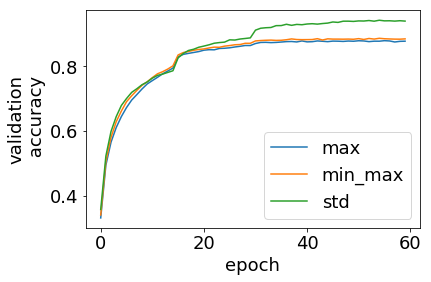

In [22]:
for norm, metrics in metrics_norms.items():
    h = metrics[1].monitor_values['accuracies']['acc']
    h = ut.moving_average(h, periods=1)
    plt.plot(h, label=norm)
plt.xlabel('epoch')
plt.ylabel('validation\n accuracy')
plt.legend()
# plt.savefig('../img/cifar10_cnn_validation_cmp.pdf')
# plt.savefig('../img/cifar10_cnn_validation_cmp.png')

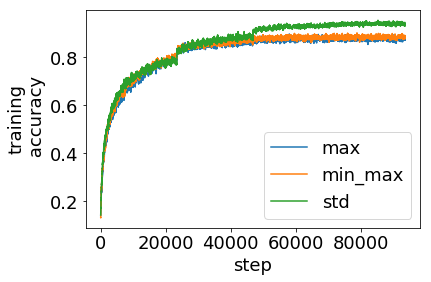

In [21]:
for norm, metrics in metrics_norms.items():
    h = metrics[0].monitor_values['accuracies']['acc']
    h = ut.moving_average(h, periods=100)
    plt.plot(h, label=norm)
plt.xlabel('step')
plt.ylabel('training\n accuracy')
plt.legend()
plt.legend()
# plt.savefig('../img/cifar10_cnn_training_cmp.pdf')
# plt.savefig('../img/cifar10_cnn_training_cmp.png')